In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import os
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import json
import torch.optim as optim
from collections import Counter
import torchaudio
from torchvision import transforms
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [5]:
data = pd.read_csv("/kaggle/input/sound-of-114-species-of-birds-till-2022/Birds Voice.csv")
data

,common_name,scientific_name,recordist_name,recording_length,Date,TYPE,xc_id,Time,Country,Download_link
0,Common Ostrich,Struthio camelus australis,Frank Lambert,0:53,2019-10-30,call,XC516153,08:05,South Africa,https://xeno-canto.org/516153/download
1,Common Ostrich,Struthio camelus,Jeremy Hegge,0:26,2014-11-20,call,XC208209,04:00,South Africa,https://xeno-canto.org/208209/download
2,Common Ostrich,Struthio camelus,Jeremy Hegge,0:04,2014-11-21,call,XC208128,06:00,South Africa,https://xeno-canto.org/208128/download
3,Common Ostrich,Struthio camelus,Derek Solomon,0:11,2010-02-09,call,XC46725,07:00,South Africa,https://xeno-canto.org/46725/download
4,Common Ostrich,Struthio camelus,Morioka Zoological Park ZOOMO,1:47,2021-09-06,"voice during egg laying, zoo collection",XC675445,17:00,Japan,https://xeno-canto.org/675445/download
...,...,...,...,...,...,...,...,...,...,...
2156,Black-fronted Piping Guan,Pipile jacutinga,Peter Boesman,0:06,2004-08-06,song,XC228155,05:45,Brazil,https://xeno-canto.org/228155/download
2157,Black-fronted Piping Guan,Pipile jacutinga,Robson Silva e Silva,0:02,2012-09-19,wing sounds,XC110142,08:05,Brazil,https://xeno-canto.org/110142/download
2158,Black-fronted Piping Guan,Pipile jacutinga,Robson Silva e Silva,0:04,2012-09-19,song,XC110141,08:05,Brazil,https://xeno-canto.org/110141/download
2159,Black-fronted Piping Guan,Pipile jacutinga,Jeremy Minns,0:05,2003-10-08,wing sounds while displaying,XC85349,06:44,Brazil,https://xeno-canto.org/85349/download


In [6]:
def analyze_audio_distribution(root_dir):
    """
    Analyze the distribution of audio files across different classes
    
    Args:
        root_dir (str): Path to root directory containing class folders
        
    Returns:
        pandas.DataFrame: Distribution statistics
    """
    distribution_data = []
    
    # Walk through the directory structure
    for class_folder in os.listdir(root_dir):
        class_path = os.path.join(root_dir, class_folder)
        
        if os.path.isdir(class_path):
            # Count audio files in this class
            audio_files = [f for f in os.listdir(class_path) if f.endswith('.mp3')]
            num_files = len(audio_files)
            
            # Get total duration if needed (commented out for speed)
            # total_duration = sum(get_audio_duration(os.path.join(class_path, f)) 
            #                     for f in audio_files)
            
            distribution_data.append({
                'class_name': class_folder.replace('_sound', ''),  # Clean up folder name
                'num_files': num_files,
                # 'total_duration': total_duration,
                # 'avg_duration': total_duration / num_files if num_files > 0 else 0
            })
    
    # Convert to DataFrame
    df = pd.DataFrame(distribution_data)
    
    # Sort by number of files
    df = df.sort_values('num_files', ascending=False)
    
    return df

In [5]:
def plot_distribution(df, output_dir='plots'):
    """
    Create various plots to visualize the distribution
    
    Args:
        df (pandas.DataFrame): Distribution data
        output_dir (str): Directory to save plots
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Set style
    plt.style.use('seaborn')
    
    # 1. Bar plot of number of files per class
    plt.figure(figsize=(15, 8))
    plt.bar(range(len(df)), df['num_files'])
    plt.xticks(range(len(df)), df['class_name'], rotation=90)
    plt.title('Number of Audio Files per Bird Species')
    plt.xlabel('Species')
    plt.ylabel('Number of Files')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'files_per_class_bar.png'))
    plt.show()  # Show plot before closing
    plt.close()
    
    # 2. Horizontal bar plot (top 20 classes)
    plt.figure(figsize=(12, 8))
    top_20 = df.head(20)
    plt.barh(range(len(top_20)), top_20['num_files'])
    plt.yticks(range(len(top_20)), top_20['class_name'])
    plt.title('Top 20 Bird Species by Number of Audio Files')
    plt.xlabel('Number of Files')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'top_20_classes.png'))
    plt.show()  # Show plot before closing
    plt.close()
    
    # 3. Distribution histogram
    plt.figure(figsize=(10, 6))
    plt.hist(df['num_files'], bins=30, edgecolor='black')
    plt.title('Distribution of Number of Files per Class')
    plt.xlabel('Number of Files')
    plt.ylabel('Number of Classes')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'distribution_histogram.png'))
    plt.show()  # Show plot before closing
    plt.close()
    
    # 4. Box plot
    plt.figure(figsize=(8, 6))
    plt.boxplot(df['num_files'])
    plt.title('Box Plot of Files per Class')
    plt.ylabel('Number of Files')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'boxplot.png'))
    plt.show()  # Show plot before closing
    plt.close()
    
    return

In [6]:
def print_statistics(df):
    """
    Print summary statistics about the distribution
    
    Args:
        df (pandas.DataFrame): Distribution data
    """
    stats = {
        'Total number of classes': len(df),
        'Total number of files': df['num_files'].sum(),
        'Average files per class': df['num_files'].mean(),
        'Median files per class': df['num_files'].median(),
        'Std dev of files per class': df['num_files'].std(),
        'Min files in a class': df['num_files'].min(),
        'Max files in a class': df['num_files'].max(),
        'Classes with >10 files': len(df[df['num_files'] > 10]),
        'Classes with <5 files': len(df[df['num_files'] < 5])
    }
    
    print("\nDistribution Statistics:")
    print("-" * 50)
    for key, value in stats.items():
        print(f"{key}: {value:.2f}")
    
    print("\nTop 10 Classes by Number of Files:")
    print("-" * 50)
    print(df.head(10)[['class_name', 'num_files']].to_string(index=False))
    
    print("\nBottom 10 Classes by Number of Files:")
    print("-" * 50)
    print(df.tail(10)[['class_name', 'num_files']].to_string(index=False))


In [7]:
root_dir = "/kaggle/input/sound-of-114-species-of-birds-till-2022/Voice of Birds/Voice of Birds"

# Analyze distribution
print("Analyzing audio file distribution...")
df = analyze_audio_distribution(root_dir)

# Print statistics
print_statistics(df)

# Save distribution data
df.to_csv('class_distribution.csv', index=False)
print("\nAnalysis complete! Check the 'plots' directory for visualizations.")

Analyzing audio file distribution...

Distribution Statistics:
--------------------------------------------------
Total number of classes: 114.00
Total number of files: 2161.00
Average files per class: 18.96
Median files per class: 20.00
Std dev of files per class: 10.79
Min files in a class: 1.00
Max files in a class: 30.00
Classes with >10 files: 80.00
Classes with <5 files: 14.00

Top 10 Classes by Number of Files:
--------------------------------------------------
               class_name  num_files
           Little Tinamou         30
          Spotted Nothura         30
  Orange-footed Scrubfowl         30
 Rufous-headed Chachalaca         30
Blue-throated Piping Guan         30
      Speckled Chachalaca         30
             Grey Tinamou         30
       Variegated Tinamou         30
  West Mexican Chachalaca         30
     Colombian Chachalaca         30

Bottom 10 Classes by Number of Files:
--------------------------------------------------
          class_name  num_file

Creating visualization plots...


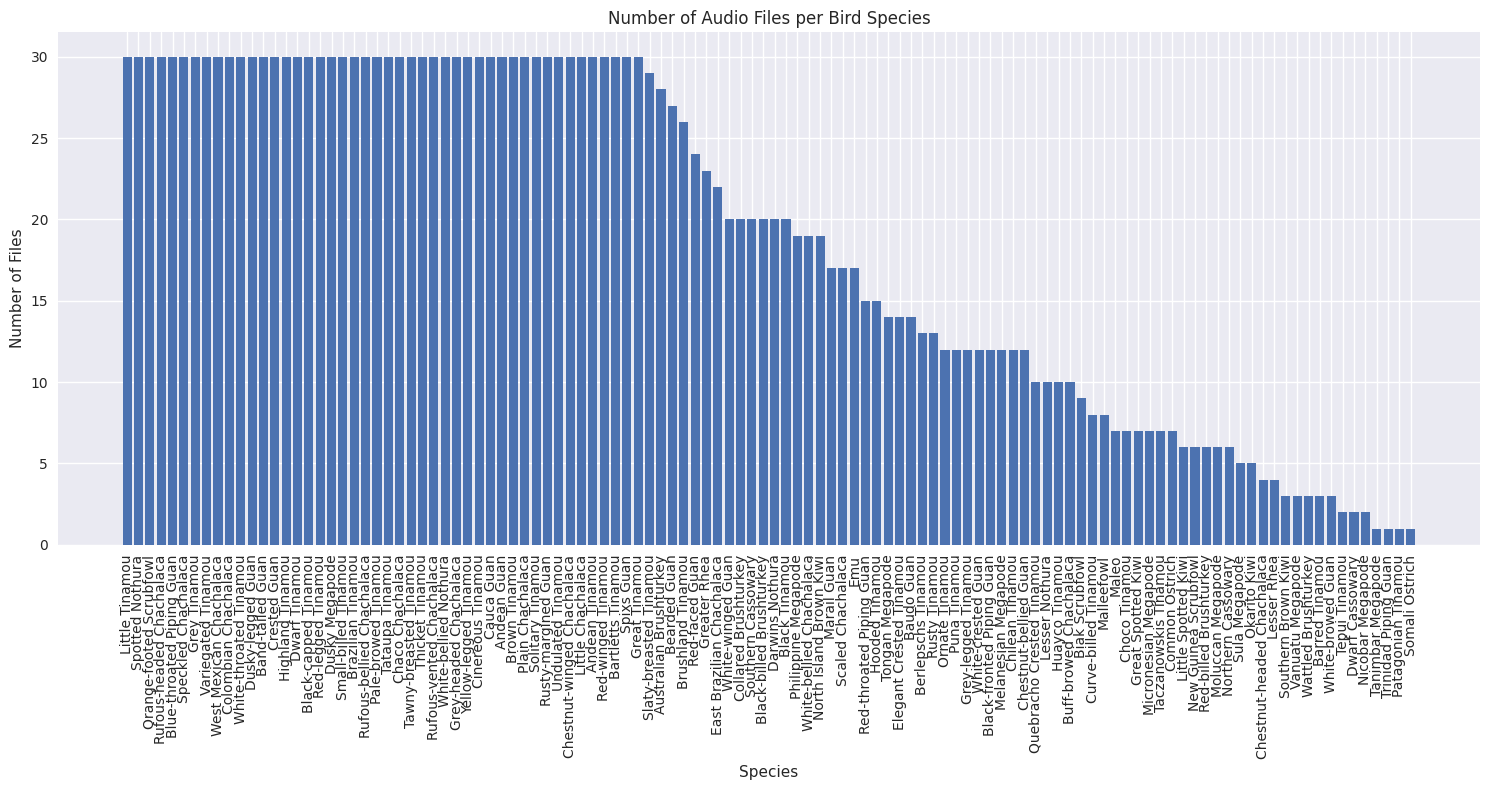

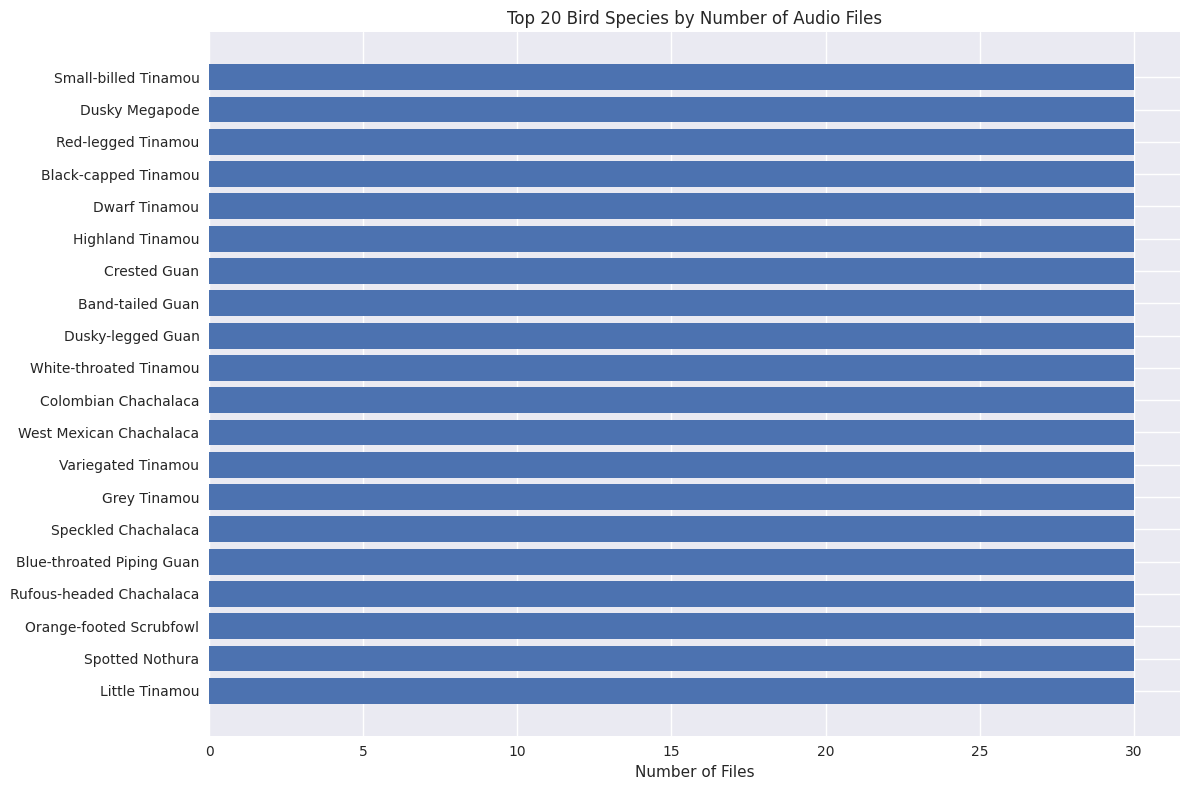

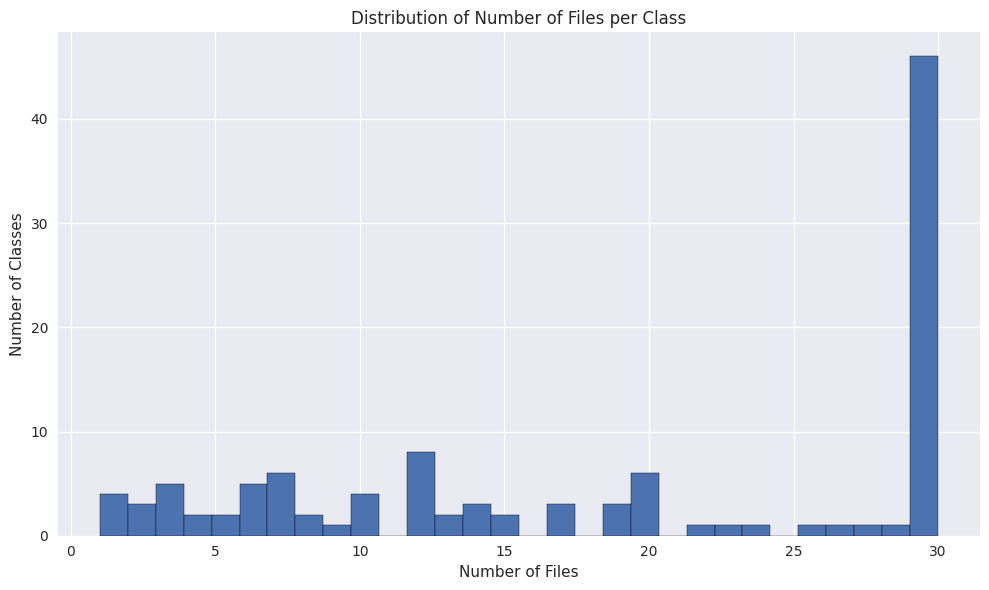

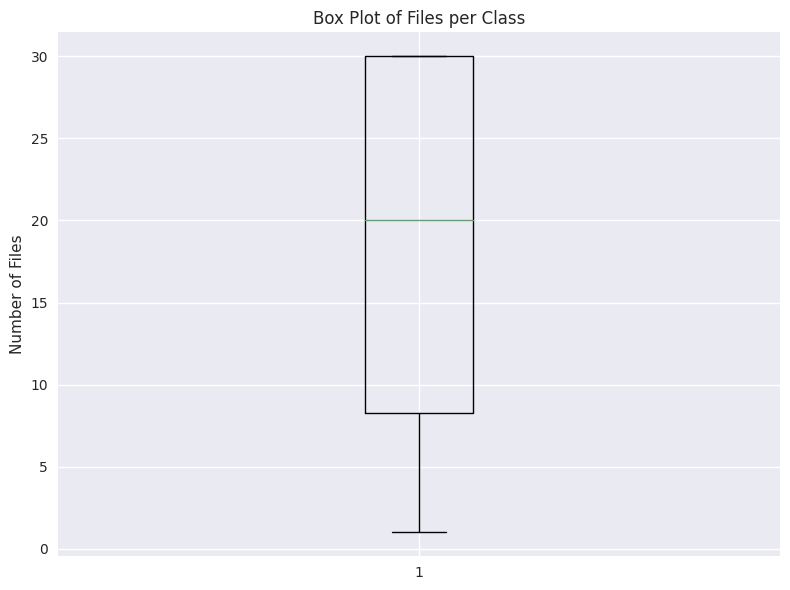

In [8]:
# Create plots
print("Creating visualization plots...")
plot_distribution(df)


In [81]:
import random

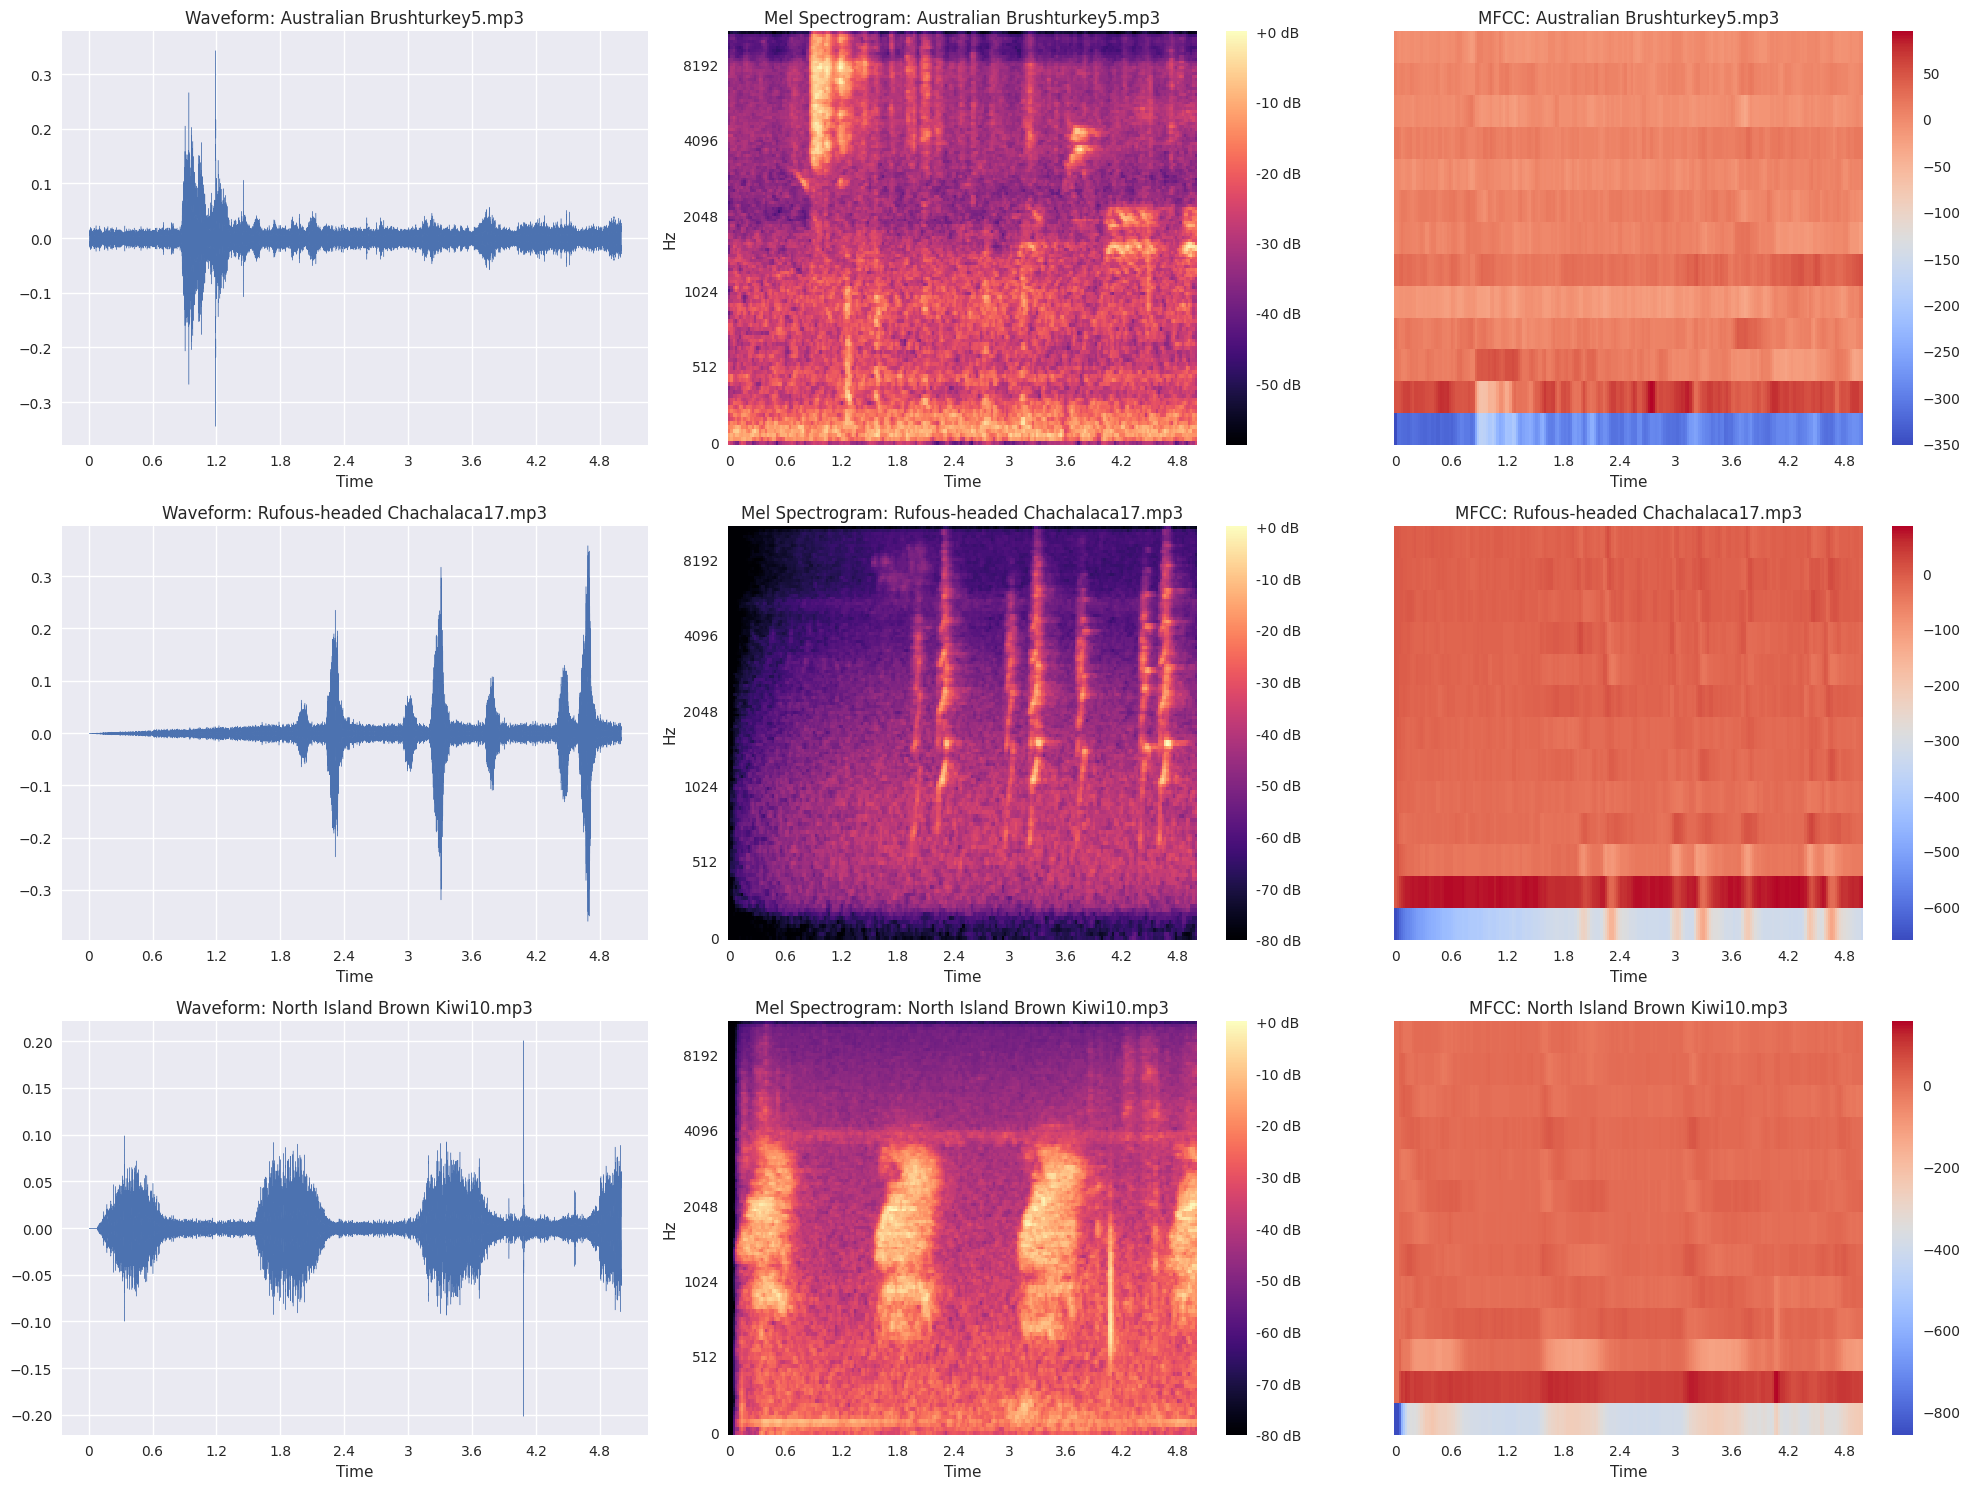

In [85]:
def plot_audio_features(audio_files, num_samples=3):
   """Plot waveform, spectrograms and MFCCs for sample audio files"""
   fig, axes = plt.subplots(num_samples, 3, figsize=(20, 5*num_samples))
   
   sample_files = np.random.choice(audio_files, num_samples, replace=False)
   
   for idx, audio_file in enumerate(sample_files):
       signal, sr = librosa.load(audio_file, sr=22050, duration=5.0)
       filename = os.path.basename(audio_file)
       
       # Plot Waveform
       librosa.display.waveshow(signal, sr=sr, ax=axes[idx,0])
       axes[idx,0].set_title(f'Waveform: {filename}')
       
       # Plot Spectrogram
       mel_spec = librosa.feature.melspectrogram(y=signal, sr=sr)
       mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
       img = librosa.display.specshow(mel_spec_db, y_axis='mel', x_axis='time', ax=axes[idx,1])
       axes[idx,1].set_title(f'Mel Spectrogram: {filename}')
       fig.colorbar(img, ax=axes[idx,1], format='%+2.0f dB')
       
       # Plot MFCC
       mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13)
       img = librosa.display.specshow(mfcc, x_axis='time', ax=axes[idx,2])
       axes[idx,2].set_title(f'MFCC: {filename}')
       fig.colorbar(img, ax=axes[idx,2])
   
   plt.tight_layout()
   plt.show()
     
# Usage
plot_audio_features(audio_files, num_samples=3)

In [7]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchaudio
from torchvision import transforms
import os
from datetime import datetime

# 1. Custom Dataset
class BirdSoundDataset(Dataset):
    def __init__(self, audio_files, labels, transform=None):
        self.audio_files = audio_files
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        audio_path = self.audio_files[idx]
        label = self.labels[idx]
        
        signal, sr = librosa.load(audio_path, sr=22050, duration=5.0)
        features = extract_features(signal, sr, fixed_length=216)
        features_tensor = torch.FloatTensor(features['mel_spec']).unsqueeze(0)
        return features_tensor, torch.tensor(label, dtype=torch.long)  # Ensure long type

## Random Forest

In [8]:
def train_random_forest(train_files, train_labels, val_files, val_labels):
   from sklearn.ensemble import RandomForestClassifier
   import numpy as np
   
   # Function to extract features from audio file
   def extract_features_for_rf(audio_path):
       signal, sr = librosa.load(audio_path, sr=22050, duration=5.0)
       features = extract_features(signal, sr, fixed_length=216)
       mel_spec = features['mel_spec']
       # Flatten the mel spectrogram and get summary statistics
       return np.concatenate([
           mel_spec.mean(axis=1),  # Frequency mean
           mel_spec.std(axis=1),   # Frequency std
           mel_spec.mean(axis=0),  # Time mean
           mel_spec.std(axis=0),   # Time std
           [mel_spec.min(), mel_spec.max(), mel_spec.mean(), mel_spec.std()]
       ])

   # Extract features for training set
   X_train = np.array([extract_features_for_rf(f) for f in tqdm(train_files, desc='Processing training files')])
   X_val = np.array([extract_features_for_rf(f) for f in tqdm(val_files, desc='Processing validation files')])
   
   # Train Random Forest
   rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
   rf.fit(X_train, train_labels)
   
   # Evaluate
   train_acc = rf.score(X_train, train_labels)
   val_acc = rf.score(X_val, val_labels)
   
   print(f"\nRandom Forest Results:")
   print(f"Training Accuracy: {train_acc:.4f}")
   print(f"Validation Accuracy: {val_acc:.4f}")
   
   return rf, X_train, X_val

In [19]:
def extract_features(signal, sr, fixed_length=216):  # Or choose appropriate length
    mel_spec = librosa.feature.melspectrogram(y=signal, sr=sr)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    # Pad or truncate to fixed length
    if mel_spec_db.shape[1] > fixed_length:
        mel_spec_db = mel_spec_db[:, :fixed_length]
    elif mel_spec_db.shape[1] < fixed_length:
        pad_width = fixed_length - mel_spec_db.shape[1]
        mel_spec_db = np.pad(mel_spec_db, ((0, 0), (0, pad_width)))
    
    return {
        'mel_spec': mel_spec_db,
        'mfcc': librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13),
        'chroma': librosa.feature.chroma_stft(y=signal, sr=sr)
    }

In [13]:
def analyze_class_distribution(root_dir):
    """
    Analyze the distribution of samples across classes
    """
    class_distribution = {}
    
    for class_folder in os.listdir(root_dir):
        class_path = os.path.join(root_dir, class_folder)
        if os.path.isdir(class_path):
            n_samples = len([f for f in os.listdir(class_path) if f.endswith('.mp3')])
            class_distribution[class_folder] = n_samples
    
    return class_distribution

In [49]:
def prepare_dataset(root_dir, min_samples=2):
    """ Prepare dataset ensuring minimum samples per class """
    # Analyze distribution
    class_distribution = analyze_class_distribution(root_dir)
    
    # Filter classes with sufficient samples
    valid_classes = {cls: count for cls, count in class_distribution.items() if count >= min_samples}
    
    # Prepare data lists
    audio_files = []
    labels = []
    
    # Create label mapping
    label_to_idx = {cls: idx for idx, cls in enumerate(sorted(valid_classes.keys()))}
    
    # Collect files from valid classes
    for class_name, class_idx in label_to_idx.items():
        class_path = os.path.join(root_dir, class_name)
        class_files = [os.path.join(class_path, f) for f in os.listdir(class_path) if f.endswith('.mp3')]
        audio_files.extend(class_files)
        labels.extend([class_idx] * len(class_files))
    
    return audio_files, labels, label_to_idx, class_distribution

In [11]:
def split_dataset(audio_files, labels, test_size=0.2):
    """
    Split dataset handling stratification carefully
    """
    # Convert to numpy arrays for easier handling
    X = np.array(audio_files)
    y = np.array(labels)
    
    # Get class distribution
    class_counts = Counter(y)
    
    # For classes with only one sample, put it in training set
    single_sample_mask = np.isin(y, [cls for cls, count in class_counts.items() if count == 1])
    
    # Split multi-sample classes
    multi_sample_mask = ~single_sample_mask
    if np.any(multi_sample_mask):
        X_multi = X[multi_sample_mask]
        y_multi = y[multi_sample_mask]
        
        # Perform stratified split on multi-sample classes
        X_train, X_val, y_train, y_val = train_test_split(
            X_multi, y_multi,
            test_size=test_size,
            stratify=y_multi,
            random_state=42
        )
    else:
        X_train, X_val = [], []
        y_train, y_val = [], []
    
    # Add single-sample classes to training set
    if np.any(single_sample_mask):
        X_train = np.concatenate([X_train, X[single_sample_mask]])
        y_train = np.concatenate([y_train, y[single_sample_mask]])
    
    return X_train, X_val, y_train, y_val


In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set paths
root_dir = "/kaggle/input/sound-of-114-species-of-birds-till-2022/Voice of Birds/Voice of Birds"  # Adjust this path

audio_files, labels, label_to_idx, class_distribution = prepare_dataset(root_dir)

# Print distribution statistics
print("\nClass distribution statistics:")
print(f"Total classes: {len(class_distribution)}")
print(f"Classes with >1 sample: {sum(1 for count in class_distribution.values() if count > 1)}")
print(f"Classes with 1 sample: {sum(1 for count in class_distribution.values() if count == 1)}")

# Split dataset
train_files, val_files, train_labels, val_labels = split_dataset(audio_files, labels)

print("\nSplit statistics:")
print(f"Training samples: {len(train_files)}")
print(f"Validation samples: {len(val_files)}")

# Print class distribution in splits
train_dist = Counter(train_labels)
val_dist = Counter(val_labels)
print("\nClass distribution in splits:")
print(f"Number of classes in training: {len(train_dist)}")
print(f"Number of classes in validation: {len(val_dist)}")



Using device: cpu

Class distribution statistics:
Total classes: 114
Classes with >1 sample: 110
Classes with 1 sample: 4

Split statistics:
Training samples: 1725
Validation samples: 432

Class distribution in splits:
Number of classes in training: 110
Number of classes in validation: 107


In [20]:
rf_model, X_train, X_val = train_random_forest(train_files, train_labels, val_files, val_labels)


Processing training files:   3%|▎         | 58/1725 [00:04<02:00, 13.81it/s]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Processing training files:   4%|▍         | 66/1725 [00:04<01:51, 14.82it/s]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Processing training files:   8%|▊         | 142/1725 [00:10<01:54, 13.80it/s]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Processing training files:  12%|█▏        | 209/1725 [00:16<01:49, 13.88it/s]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Processing training files:  16%|█▌        | 273/1725 [00:20<01:43, 14.09it/s]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Processing training files:  17%|█▋        | 289/1725 [00:21<01:41, 14.21it/s]Warning: Xing stream size off by m


Random Forest Results:
Training Accuracy: 0.9623
Validation Accuracy: 0.6389


## Model 1 - CNN Model

In [40]:
class CNNModel(nn.Module):
   def __init__(self, input_shape, num_classes):
       super(CNNModel, self).__init__()
       height, width = input_shape
       
       self.conv1 = nn.Sequential(
           nn.Conv2d(1, 32, kernel_size=3, padding=1),
           nn.BatchNorm2d(32),
           nn.ReLU(),
           nn.MaxPool2d(2)
       )
       
       self.conv2 = nn.Sequential(
           nn.Conv2d(32, 64, kernel_size=3, padding=1),
           nn.BatchNorm2d(64), 
           nn.ReLU(),
           nn.MaxPool2d(2)
       )
       
       # Fixed conv3 (was being assigned to conv2)
       self.conv3 = nn.Sequential(
           nn.Conv2d(64, 64, kernel_size=3, padding=1),
           nn.BatchNorm2d(64), 
           nn.ReLU(),
           nn.MaxPool2d(2)
       )
       
       self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))
       self.flat_features = 64 * 4 * 4
       
       self.fc = nn.Sequential(
           nn.Linear(self.flat_features, 256),
           nn.ReLU(),
           nn.Dropout(0.3),
           nn.Linear(256, num_classes)
       )
   
   def forward(self, x):
       if len(x.shape) == 3:
           x = x.unsqueeze(1)
       x = self.conv1(x)
       x = self.conv2(x)
       x = self.conv3(x) 
       x = self.adaptive_pool(x)
       x = x.view(x.size(0), -1)
       x = self.fc(x)
       return x

In [29]:
# class CNNModel(nn.Module):
#     def __init__(self, num_classes=10):
#         super(CNNModel, self).__init__()
#         self.conv1 = nn.Sequential(
#             nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2)
#         )
#         self.conv2 = nn.Sequential(
#             nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2)
#         )
#         self.conv3 = nn.Sequential(
#             nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2)
#         )
#         self.conv4 = nn.Sequential(
#             nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2)
#         )
#         self.flatten = nn.Flatten()
#         self.fc1 = nn.Linear(128 * 8 * 8, 256)
#         self.fc2 = nn.Linear(256, num_classes)
#     def forward(self, x):
#     # Add channel dimension
#         x = x.unsqueeze(1)
#         x = self.conv1(x)
#         x = self.conv2(x)
#         x = self.conv3(x)
#         x = self.conv4(x)
#         x = self.flatten(x)
#         x = self.fc1(x)
#         x = self.fc2(x)
#         return x

## Model 2 - LSTM Model

In [51]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(hidden_size*2, hidden_size, batch_first=True, bidirectional=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size*2, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # Reshape input if necessary
        if len(x.shape) == 4:  # (batch, channels, freq, time)
            x = x.squeeze(1)    # Remove channel dimension
            x = x.transpose(1, 2)  # Swap freq and time dimensions
        
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = x[:, -1, :]  # Take the last time step
        x = self.fc(x)
        return x

## Model 3 - Transformer Model

In [31]:
class TransformerModel(nn.Module):
    def __init__(self, input_size, num_classes, nhead=8, num_encoder_layers=6):
        super(TransformerModel, self).__init__()
        
        self.pos_encoder = PositionalEncoding(input_size)
        encoder_layers = nn.TransformerEncoderLayer(input_size, nhead, dim_feedforward=2048)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_encoder_layers)
        
        self.fc = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # Reshape input if necessary
        if len(x.shape) == 4:  # (batch, channels, freq, time)
            x = x.squeeze(1)    # Remove channel dimension
            x = x.transpose(1, 2)  # Swap freq and time dimensions
        
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)  # Global average pooling
        x = self.fc(x)
        return x

In [32]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

In [33]:
from tqdm import tqdm
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, writer):
   best_val_loss = float('inf')
   
   for epoch in range(num_epochs):
       # Training phase
       model.train()
       running_loss = 0.0
       train_correct = 0
       train_total = 0
       
       train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1} [Train]')
       for inputs, labels in train_pbar:
           inputs, labels = inputs.float().to(device), labels.to(device)
           
           optimizer.zero_grad()
           outputs = model(inputs)
           loss = criterion(outputs, labels)
           loss.backward()
           optimizer.step()
           
           running_loss += loss.item()
           _, predicted = outputs.max(1)
           train_total += labels.size(0)
           train_correct += predicted.eq(labels).sum().item()
           
           # Update progress bar
           train_pbar.set_postfix({
               'Loss': f'{running_loss/(train_pbar.n+1):.4f}',
               'Acc': f'{100.*train_correct/train_total:.2f}%'
           })
       
       train_loss = running_loss / len(train_loader)
       train_acc = 100. * train_correct / train_total
       
       # Validation phase
       model.eval()
       val_loss = 0.0
       val_correct = 0
       val_total = 0
       
       val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}')
       with torch.no_grad():
           for inputs, labels in val_pbar:
               inputs, labels = inputs.float().to(device), labels.to(device)
               outputs = model(inputs)
               loss = criterion(outputs, labels)
               
               val_loss += loss.item()
               _, predicted = outputs.max(1)
               val_total += labels.size(0)
               val_correct += predicted.eq(labels).sum().item()
               
               # Update validation progress bar
               val_pbar.set_postfix({
                   'Loss': f'{val_loss/(val_pbar.n+1):.4f}',
                   'Acc': f'{100.*val_correct/val_total:.2f}%'
               })
       
       val_loss = val_loss / len(val_loader)
       val_acc = 100. * val_correct / val_total
       
       # TensorBoard logging
       writer.add_scalars('Loss', {
           'train': train_loss,
           'val': val_loss
       }, epoch)
       writer.add_scalars('Accuracy', {
           'train': train_acc,
           'val': val_acc
       }, epoch)
       
       print(f'\nEpoch {epoch+1}/{num_epochs} Summary:')
       print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
       print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
       
       # Save best model
       if val_loss < best_val_loss:
           best_val_loss = val_loss
           torch.save({
               'epoch': epoch,
               'model_state_dict': model.state_dict(),
               'optimizer_state_dict': optimizer.state_dict(),
               'train_loss': train_loss,
               'val_loss': val_loss,
               'train_acc': train_acc,
               'val_acc': val_acc
           }, f'best_model_{type(model).__name__}.pth')

In [42]:
def train_all_models(train_dataset, val_dataset, input_shape, num_classes, device):
   train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
   val_loader = DataLoader(val_dataset, batch_size=32)
   
   # Model configurations
   model_configs = {
       # 'cnn': {
       #     'model': CNNModel(input_shape, num_classes),
       #     'lr': 0.0001,
       # }
       #,
       # 'lstm': {
       #     'model': LSTMModel(input_shape[1], 128, num_classes),
       #     'lr': 0.001,
       # },
       'transformer': {
           'model': TransformerModel(input_shape[1], num_classes),
           'lr': 0.0001,
       }
   }
   
   criterion = nn.CrossEntropyLoss()
   num_epochs = 20
   
   for name, config in model_configs.items():
       print(f"\nTraining {name} model...")
       model = config['model'].to(device)
       optimizer = optim.Adam(model.parameters(), lr=config['lr'])
       writer = SummaryWriter(f'runs/{name}_{datetime.now().strftime("%Y%m%d-%H%M%S")}')
       
       train_model(
           model=model,
           train_loader=train_loader,
           val_loader=val_loader,
           criterion=criterion,
           optimizer=optimizer,
           num_epochs=num_epochs,
           device=device,
           writer=writer
       )
       writer.close()

In [35]:
train_dataset = BirdSoundDataset(train_files, train_labels)
val_dataset = BirdSoundDataset(val_files, val_labels)

In [36]:
input_shape = (128, 128)  # Mel spectrogram shape
num_classes = len(label_to_idx)

print(f"\nTraining Configuration:")
print(f"Number of classes: {num_classes}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Input shape: {input_shape}")

# Save label mapping for future reference
label_mapping = {v: k for k, v in label_to_idx.items()}
with open('label_mapping.json', 'w') as f:
    json.dump(label_mapping, f, indent=4)



Training Configuration:
Number of classes: 110
Training samples: 1725
Validation samples: 432
Input shape: (128, 128)


In [41]:
# Train all models
train_all_models(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    input_shape=input_shape,
    num_classes=num_classes,
    device=device
)


Training cnn model...



Epoch 1 [Train]:   6%|▌         | 3/54 [00:11<03:10,  3.74s/it, Loss=4.7222, Acc=2.08%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 1 [Train]:  11%|█         | 6/54 [00:23<03:06,  3.88s/it, Loss=4.6900, Acc=4.17%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 1 [Train]:  15%|█▍        | 8/54 [00:30<02:52,  3.74s/it, Loss=4.6983, Acc=3.52%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 1 [Train]:  17%|█▋        | 9/54 [00:34<02:47,  3.71s/it, Loss=4.6989, Acc=3.12%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 1 [Train]:  20%|██        | 11/54 [00:41<02:37,  3.66s/it, Loss=4.6923, Acc=2.56%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 1 [Train]:  24%|██▍       | 13/54 [00:49<02:37,  3.8


Epoch 1/20 Summary:
Train Loss: 4.6572, Train Acc: 1.80%
Val Loss: 4.5542, Val Acc: 2.78%



Epoch 2 [Train]:   2%|▏         | 1/54 [00:03<03:15,  3.68s/it, Loss=4.5175, Acc=0.00%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 2 [Train]:   4%|▎         | 2/54 [00:07<03:10,  3.66s/it, Loss=4.4961, Acc=1.56%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 2 [Train]:   6%|▌         | 3/54 [00:11<03:07,  3.68s/it, Loss=4.4949, Acc=3.12%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 2 [Train]:   7%|▋         | 4/54 [00:14<03:01,  3.64s/it, Loss=4.4916, Acc=3.91%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 2 [Train]:  11%|█         | 6/54 [00:21<02:56,  3.67s/it, Loss=4.5014, Acc=2.60%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 2 [Train]:  13%|█▎        | 7/54 [00:25<02:52,  3.66s


Epoch 2/20 Summary:
Train Loss: 4.5192, Train Acc: 3.42%
Val Loss: 4.4269, Val Acc: 5.79%



Epoch 3 [Train]:   4%|▎         | 2/54 [00:07<03:09,  3.64s/it, Loss=4.3536, Acc=3.12%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 3 [Train]:   9%|▉         | 5/54 [00:18<03:09,  3.87s/it, Loss=4.4174, Acc=5.00%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 3 [Train]:  11%|█         | 6/54 [00:22<03:03,  3.83s/it, Loss=4.4057, Acc=5.73%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 3 [Train]:  20%|██        | 11/54 [00:40<02:39,  3.71s/it, Loss=4.4177, Acc=5.40%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 3 [Train]:  22%|██▏       | 12/54 [00:44<02:35,  3.69s/it, Loss=4.4247, Acc=5.21%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 3 [Train]:  26%|██▌       | 14/54 [00:52<02:30,  3.


Epoch 3/20 Summary:
Train Loss: 4.3737, Train Acc: 6.09%
Val Loss: 4.2848, Val Acc: 9.49%



Epoch 4 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 4 [Train]:   2%|▏         | 1/54 [00:03<03:11,  3.62s/it, Loss=4.2944, Acc=0.00%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 4 [Train]:   6%|▌         | 3/54 [00:11<03:21,  3.94s/it, Loss=4.3189, Acc=8.33%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 4 [Train]:   7%|▋         | 4/54 [00:15<03:07,  3.75s/it, Loss=4.3566, Acc=7.03%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 4 [Train]:   9%|▉         | 5/54 [00:18<03:01,  3.70s/it, Loss=4.3453, Acc=7.50%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 4 [Train]:  15%|█▍        | 8/54 [00:29<02:46,  3.62s/it, Loss=4.3196, Acc=7.81%]Warn


Epoch 4/20 Summary:
Train Loss: 4.2301, Train Acc: 8.23%
Val Loss: 4.1596, Val Acc: 14.81%



Epoch 5 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 5 [Train]:   2%|▏         | 1/54 [00:03<03:14,  3.66s/it, Loss=4.3148, Acc=6.25%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 5 [Train]:  15%|█▍        | 8/54 [00:29<02:56,  3.83s/it, Loss=4.2052, Acc=9.77%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 5 [Train]:  20%|██        | 11/54 [00:40<02:38,  3.68s/it, Loss=4.1884, Acc=9.09%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 5 [Train]:  24%|██▍       | 13/54 [00:47<02:30,  3.67s/it, Loss=4.1635, Acc=9.86%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 5 [Train]:  26%|██▌       | 14/54 [00:51<02:26,  3.66s/it, Loss=4.1645, Acc=9.60%]W


Epoch 5/20 Summary:
Train Loss: 4.0929, Train Acc: 9.80%
Val Loss: 4.0195, Val Acc: 16.67%



Epoch 6 [Train]:   2%|▏         | 1/54 [00:03<03:13,  3.66s/it, Loss=3.9963, Acc=6.25%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 6 [Train]:   4%|▎         | 2/54 [00:07<03:08,  3.62s/it, Loss=3.9198, Acc=7.81%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 6 [Train]:   6%|▌         | 3/54 [00:10<03:01,  3.57s/it, Loss=3.8959, Acc=12.50%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 6 [Train]:   9%|▉         | 5/54 [00:18<02:59,  3.66s/it, Loss=3.8821, Acc=12.50%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 6 [Train]:  11%|█         | 6/54 [00:21<02:53,  3.62s/it, Loss=3.8917, Acc=12.50%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 6 [Train]:  15%|█▍        | 8/54 [00:29<02:46,  3.


Epoch 6/20 Summary:
Train Loss: 3.9332, Train Acc: 12.81%
Val Loss: 3.8878, Val Acc: 17.36%



Epoch 7 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 7 [Train]:   2%|▏         | 1/54 [00:04<03:39,  4.15s/it, Loss=3.9076, Acc=15.62%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 7 [Train]:   4%|▎         | 2/54 [00:07<03:18,  3.81s/it, Loss=3.9198, Acc=14.06%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 7 [Train]:   7%|▋         | 4/54 [00:14<03:02,  3.64s/it, Loss=3.8322, Acc=16.41%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 7 [Train]:   9%|▉         | 5/54 [00:18<02:57,  3.63s/it, Loss=3.8596, Acc=16.25%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 7 [Train]:  11%|█         | 6/54 [00:22<02:53,  3.61s/it, Loss=3.8084, Acc=17.71%


Epoch 7/20 Summary:
Train Loss: 3.7881, Train Acc: 16.06%
Val Loss: 3.7751, Val Acc: 19.21%



Epoch 8 [Train]:   4%|▎         | 2/54 [00:07<03:07,  3.60s/it, Loss=3.6632, Acc=18.75%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 8 [Train]:   6%|▌         | 3/54 [00:10<03:05,  3.63s/it, Loss=3.6632, Acc=17.71%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 8 [Train]:  11%|█         | 6/54 [00:21<02:54,  3.64s/it, Loss=3.6656, Acc=18.75%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 8 [Train]:  15%|█▍        | 8/54 [00:29<02:53,  3.77s/it, Loss=3.6893, Acc=16.41%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 8 [Train]:  20%|██        | 11/54 [00:40<02:38,  3.69s/it, Loss=3.7319, Acc=15.06%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 8 [Train]:  24%|██▍       | 13/54 [00:47<02:29,


Epoch 8/20 Summary:
Train Loss: 3.6578, Train Acc: 18.03%
Val Loss: 3.6495, Val Acc: 23.38%



Epoch 9 [Train]:   2%|▏         | 1/54 [00:03<03:11,  3.61s/it, Loss=3.5483, Acc=21.88%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 9 [Train]:   4%|▎         | 2/54 [00:07<03:07,  3.61s/it, Loss=3.5412, Acc=23.44%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 9 [Train]:  15%|█▍        | 8/54 [00:29<02:50,  3.70s/it, Loss=3.7101, Acc=18.75%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 9 [Train]:  17%|█▋        | 9/54 [00:33<02:47,  3.73s/it, Loss=3.6931, Acc=18.40%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 9 [Train]:  19%|█▊        | 10/54 [00:38<02:56,  4.02s/it, Loss=3.6866, Acc=17.81%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 9 [Train]:  20%|██        | 11/54 [00:43<03:01,


Epoch 9/20 Summary:
Train Loss: 3.5415, Train Acc: 19.88%
Val Loss: 3.5342, Val Acc: 25.69%



Epoch 10 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 10 [Train]:  13%|█▎        | 7/54 [00:25<02:50,  3.63s/it, Loss=3.5781, Acc=20.54%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 10 [Train]:  22%|██▏       | 12/54 [00:44<02:33,  3.67s/it, Loss=3.5355, Acc=20.05%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 10 [Train]:  24%|██▍       | 13/54 [00:47<02:29,  3.64s/it, Loss=3.5324, Acc=19.95%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 10 [Train]:  30%|██▉       | 16/54 [00:58<02:17,  3.63s/it, Loss=3.4545, Acc=21.88%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 10 [Train]:  31%|███▏      | 17/54 [01:03<02:25,  3.94s/it, Loss=3.4540, 


Epoch 10/20 Summary:
Train Loss: 3.3969, Train Acc: 24.46%
Val Loss: 3.4366, Val Acc: 24.54%



Epoch 11 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 11 [Train]:   2%|▏         | 1/54 [00:03<03:12,  3.64s/it, Loss=3.3294, Acc=18.75%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 11 [Train]:   6%|▌         | 3/54 [00:10<03:04,  3.62s/it, Loss=3.3453, Acc=25.00%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 11 [Train]:  11%|█         | 6/54 [00:22<03:01,  3.77s/it, Loss=3.3143, Acc=26.04%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 11 [Train]:  13%|█▎        | 7/54 [00:25<02:54,  3.72s/it, Loss=3.3134, Acc=25.89%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 11 [Train]:  15%|█▍        | 8/54 [00:29<02:50,  3.71s/it, Loss=3.2847, Acc=


Epoch 11/20 Summary:
Train Loss: 3.2519, Train Acc: 26.20%
Val Loss: 3.3258, Val Acc: 27.78%



Epoch 12 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 12 [Train]:   4%|▎         | 2/54 [00:07<03:21,  3.88s/it, Loss=3.0934, Acc=31.25%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 12 [Train]:   6%|▌         | 3/54 [00:11<03:12,  3.77s/it, Loss=3.2802, Acc=27.08%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 12 [Train]:  11%|█         | 6/54 [00:22<02:57,  3.70s/it, Loss=3.2410, Acc=25.00%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 12 [Train]:  15%|█▍        | 8/54 [00:29<02:48,  3.67s/it, Loss=3.2574, Acc=25.39%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 12 [Train]:  31%|███▏      | 17/54 [01:03<02:16,  3.68s/it, Loss=3.1493, Acc


Epoch 12/20 Summary:
Train Loss: 3.1744, Train Acc: 26.84%
Val Loss: 3.2301, Val Acc: 27.08%



Epoch 13 [Train]:   4%|▎         | 2/54 [00:07<03:07,  3.60s/it, Loss=3.1847, Acc=28.12%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 13 [Train]:  11%|█         | 6/54 [00:21<02:59,  3.75s/it, Loss=3.1438, Acc=30.21%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 13 [Train]:  15%|█▍        | 8/54 [00:29<02:56,  3.85s/it, Loss=3.1413, Acc=29.69%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 13 [Train]:  17%|█▋        | 9/54 [00:33<02:50,  3.80s/it, Loss=3.1134, Acc=31.25%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 13 [Train]:  20%|██        | 11/54 [00:40<02:39,  3.70s/it, Loss=3.0743, Acc=32.39%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 13 [Train]:  22%|██▏       | 12/54 [00:44<


Epoch 13/20 Summary:
Train Loss: 3.0789, Train Acc: 28.58%
Val Loss: 3.1540, Val Acc: 31.71%



Epoch 14 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 14 [Train]:   6%|▌         | 3/54 [00:11<03:10,  3.74s/it, Loss=2.9528, Acc=34.38%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 14 [Train]:  17%|█▋        | 9/54 [00:33<02:47,  3.71s/it, Loss=3.0534, Acc=28.82%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 14 [Train]:  19%|█▊        | 10/54 [00:36<02:41,  3.68s/it, Loss=3.0564, Acc=28.75%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 14 [Train]:  22%|██▏       | 12/54 [00:44<02:42,  3.87s/it, Loss=3.0180, Acc=28.65%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 14 [Train]:  24%|██▍       | 13/54 [00:48<02:36,  3.81s/it, Loss=3.0197, A


Epoch 14/20 Summary:
Train Loss: 2.9724, Train Acc: 31.25%
Val Loss: 3.0616, Val Acc: 31.25%



Epoch 15 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 15 [Train]:   4%|▎         | 2/54 [00:07<03:09,  3.65s/it, Loss=2.7323, Acc=35.94%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 15 [Train]:   6%|▌         | 3/54 [00:10<03:06,  3.65s/it, Loss=2.7276, Acc=34.38%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 15 [Train]:   9%|▉         | 5/54 [00:18<02:58,  3.65s/it, Loss=2.7314, Acc=38.12%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 15 [Train]:  19%|█▊        | 10/54 [00:37<02:47,  3.80s/it, Loss=2.7205, Acc=37.81%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 15 [Train]:  22%|██▏       | 12/54 [00:44<02:36,  3.72s/it, Loss=2.7499, Ac


Epoch 15/20 Summary:
Train Loss: 2.8728, Train Acc: 33.57%
Val Loss: 2.9987, Val Acc: 33.56%



Epoch 16 [Train]:   2%|▏         | 1/54 [00:03<03:11,  3.61s/it, Loss=2.7643, Acc=31.25%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 16 [Train]:   4%|▎         | 2/54 [00:07<03:08,  3.63s/it, Loss=2.8119, Acc=29.69%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 16 [Train]:   9%|▉         | 5/54 [00:18<03:05,  3.79s/it, Loss=2.7648, Acc=33.75%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 16 [Train]:  15%|█▍        | 8/54 [00:29<02:49,  3.69s/it, Loss=2.7453, Acc=32.42%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 16 [Train]:  17%|█▋        | 9/54 [00:33<02:45,  3.69s/it, Loss=2.7566, Acc=32.99%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 16 [Train]:  24%|██▍       | 13/54 [00:49<0


Epoch 16/20 Summary:
Train Loss: 2.8097, Train Acc: 34.49%
Val Loss: 2.9300, Val Acc: 35.65%



Epoch 17 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 17 [Train]:   4%|▎         | 2/54 [00:07<03:16,  3.79s/it, Loss=2.7923, Acc=28.12%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 17 [Train]:   6%|▌         | 3/54 [00:11<03:08,  3.70s/it, Loss=2.7900, Acc=27.08%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 17 [Train]:   7%|▋         | 4/54 [00:14<03:00,  3.61s/it, Loss=2.6670, Acc=31.25%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 17 [Train]:  11%|█         | 6/54 [00:21<02:53,  3.62s/it, Loss=2.6631, Acc=32.81%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 17 [Train]:  13%|█▎        | 7/54 [00:25<02:48,  3.58s/it, Loss=2.6343, Acc=


Epoch 17/20 Summary:
Train Loss: 2.7318, Train Acc: 34.32%
Val Loss: 2.8856, Val Acc: 38.19%



Epoch 18 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 18 [Train]:   2%|▏         | 1/54 [00:03<03:06,  3.51s/it, Loss=2.9172, Acc=34.38%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 18 [Train]:   4%|▎         | 2/54 [00:06<03:01,  3.50s/it, Loss=2.7992, Acc=32.81%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 18 [Train]:   9%|▉         | 5/54 [00:17<02:53,  3.55s/it, Loss=2.6864, Acc=37.50%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 18 [Train]:  11%|█         | 6/54 [00:21<02:51,  3.57s/it, Loss=2.7119, Acc=35.42%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 18 [Train]:  20%|██        | 11/54 [00:40<02:38,  3.69s/it, Loss=2.6446, Acc


Epoch 18/20 Summary:
Train Loss: 2.6592, Train Acc: 36.29%
Val Loss: 2.8094, Val Acc: 38.19%



Epoch 19 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 19 [Train]:   6%|▌         | 3/54 [00:10<03:05,  3.64s/it, Loss=2.6666, Acc=32.29%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 19 [Train]:   9%|▉         | 5/54 [00:18<03:05,  3.79s/it, Loss=2.5608, Acc=34.38%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 19 [Train]:  15%|█▍        | 8/54 [00:29<02:51,  3.74s/it, Loss=2.5137, Acc=38.28%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 19 [Train]:  17%|█▋        | 9/54 [00:33<02:47,  3.72s/it, Loss=2.5327, Acc=38.19%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 19 [Train]:  19%|█▊        | 10/54 [00:37<02:42,  3.69s/it, Loss=2.5109, Acc


Epoch 19/20 Summary:
Train Loss: 2.5982, Train Acc: 38.14%
Val Loss: 2.7439, Val Acc: 37.50%



Epoch 20 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 20 [Train]:   4%|▎         | 2/54 [00:08<03:28,  4.00s/it, Loss=2.3594, Acc=56.25%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 20 [Train]:   6%|▌         | 3/54 [00:11<03:16,  3.85s/it, Loss=2.3170, Acc=52.08%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 20 [Train]:   7%|▋         | 4/54 [00:15<03:06,  3.74s/it, Loss=2.3739, Acc=46.09%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 20 [Train]:   9%|▉         | 5/54 [00:19<03:01,  3.70s/it, Loss=2.4365, Acc=42.50%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 20 [Train]:  13%|█▎        | 7/54 [00:26<02:53,  3.69s/it, Loss=2.4047, Acc=


Epoch 20/20 Summary:
Train Loss: 2.5090, Train Acc: 39.88%
Val Loss: 2.7127, Val Acc: 41.44%


In [ ]:
# Train all models
train_all_models(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    input_shape=input_shape,
    num_classes=num_classes,
    device=device
)


Training lstm model...



Epoch 1 [Train]:   2%|▏         | 1/54 [00:06<05:28,  6.21s/it, Loss=4.6746, Acc=0.00%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 1 [Train]:  11%|█         | 6/54 [00:37<05:01,  6.28s/it, Loss=4.6886, Acc=0.00%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 1 [Train]:  13%|█▎        | 7/54 [00:43<04:59,  6.37s/it, Loss=4.6954, Acc=0.00%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 1 [Train]:  15%|█▍        | 8/54 [00:50<05:02,  6.57s/it, Loss=4.6968, Acc=0.00%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 1 [Train]:  17%|█▋        | 9/54 [00:58<05:02,  6.73s/it, Loss=4.6993, Acc=0.00%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 1 [Train]:  19%|█▊        | 10/54 [01:05<04:59,  6.80


Epoch 1/20 Summary:
Train Loss: 4.6848, Train Acc: 1.16%
Val Loss: 4.6222, Val Acc: 2.08%



Epoch 2 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 2 [Train]:   6%|▌         | 3/54 [00:22<06:37,  7.80s/it, Loss=4.6927, Acc=1.04%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 2 [Train]:  13%|█▎        | 7/54 [00:52<05:44,  7.32s/it, Loss=4.6697, Acc=1.34%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 2 [Train]:  20%|██        | 11/54 [01:20<05:07,  7.14s/it, Loss=4.6656, Acc=0.85%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 2 [Train]:  22%|██▏       | 12/54 [01:28<05:09,  7.37s/it, Loss=4.6598, Acc=1.04%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 2 [Train]:  24%|██▍       | 13/54 [01:35<04:58,  7.29s/it, Loss=4.6555, Acc=1.20%]W


Epoch 2/20 Summary:
Train Loss: 4.6160, Train Acc: 1.45%
Val Loss: 4.5436, Val Acc: 2.08%



Epoch 3 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 3 [Train]:   2%|▏         | 1/54 [00:07<06:39,  7.54s/it, Loss=4.5857, Acc=3.12%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 3 [Train]:   6%|▌         | 3/54 [00:21<06:09,  7.24s/it, Loss=4.5512, Acc=2.08%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 3 [Train]:   7%|▋         | 4/54 [00:28<05:59,  7.20s/it, Loss=4.5362, Acc=2.34%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 3 [Train]:   9%|▉         | 5/54 [00:36<05:50,  7.15s/it, Loss=4.5365, Acc=1.88%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 3 [Train]:  11%|█         | 6/54 [00:43<05:41,  7.11s/it, Loss=4.5455, Acc=2.08%]Warn


Epoch 3/20 Summary:
Train Loss: 4.5660, Train Acc: 1.86%
Val Loss: 4.5201, Val Acc: 2.08%



Epoch 4 [Train]:   4%|▎         | 2/54 [00:14<06:21,  7.34s/it, Loss=4.6182, Acc=1.56%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 4 [Train]:   6%|▌         | 3/54 [00:22<06:17,  7.39s/it, Loss=4.5408, Acc=1.04%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 4 [Train]:   7%|▋         | 4/54 [00:29<06:09,  7.40s/it, Loss=4.5682, Acc=0.78%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 4 [Train]:   9%|▉         | 5/54 [00:36<05:59,  7.33s/it, Loss=4.5381, Acc=1.25%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 4 [Train]:  11%|█         | 6/54 [00:43<05:47,  7.24s/it, Loss=4.5291, Acc=1.04%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 4 [Train]:  17%|█▋        | 9/54 [01:06<05:30,  7.34s


Epoch 4/20 Summary:
Train Loss: 4.5350, Train Acc: 1.97%
Val Loss: 4.5169, Val Acc: 2.31%



Epoch 5 [Train]:   2%|▏         | 1/54 [00:07<06:37,  7.51s/it, Loss=4.6214, Acc=0.00%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 5 [Train]:   4%|▎         | 2/54 [00:14<06:23,  7.37s/it, Loss=4.6249, Acc=0.00%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 5 [Train]:  19%|█▊        | 10/54 [01:13<05:26,  7.43s/it, Loss=4.5549, Acc=1.56%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 5 [Train]:  24%|██▍       | 13/54 [01:35<04:58,  7.27s/it, Loss=4.5350, Acc=1.44%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 5 [Train]:  31%|███▏      | 17/54 [02:04<04:32,  7.35s/it, Loss=4.5502, Acc=1.29%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 5 [Train]:  33%|███▎      | 18/54 [02:12<04:25,  7


Epoch 5/20 Summary:
Train Loss: 4.5204, Train Acc: 1.68%
Val Loss: 4.5014, Val Acc: 2.31%



Epoch 6 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 6 [Train]:   4%|▎         | 2/54 [00:14<06:19,  7.30s/it, Loss=4.4720, Acc=1.56%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 6 [Train]:   9%|▉         | 5/54 [00:36<05:54,  7.24s/it, Loss=4.4755, Acc=1.25%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 6 [Train]:  13%|█▎        | 7/54 [00:50<05:43,  7.31s/it, Loss=4.5238, Acc=0.89%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 6 [Train]:  22%|██▏       | 12/54 [01:28<05:11,  7.43s/it, Loss=4.5213, Acc=1.04%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 6 [Train]:  24%|██▍       | 13/54 [01:35<05:01,  7.36s/it, Loss=4.5320, Acc=0.96%]Wa


Epoch 6/20 Summary:
Train Loss: 4.5339, Train Acc: 1.51%
Val Loss: 4.4977, Val Acc: 2.31%



Epoch 7 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 7 [Train]:   2%|▏         | 1/54 [00:07<06:30,  7.37s/it, Loss=4.4883, Acc=6.25%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 7 [Train]:   6%|▌         | 3/54 [00:21<06:01,  7.10s/it, Loss=4.6062, Acc=3.12%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 7 [Train]:  11%|█         | 6/54 [00:43<05:49,  7.28s/it, Loss=4.5847, Acc=2.08%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 7 [Train]:  17%|█▋        | 9/54 [01:05<05:31,  7.36s/it, Loss=4.5536, Acc=1.74%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 7 [Train]:  24%|██▍       | 13/54 [01:35<05:02,  7.38s/it, Loss=4.5403, Acc=1.68%]War


Epoch 7/20 Summary:
Train Loss: 4.5148, Train Acc: 2.32%
Val Loss: 4.5026, Val Acc: 2.08%



Epoch 8 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 8 [Train]:   2%|▏         | 1/54 [00:07<06:14,  7.07s/it, Loss=4.5372, Acc=3.12%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 8 [Train]:   9%|▉         | 5/54 [00:36<05:58,  7.32s/it, Loss=4.5002, Acc=1.88%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 8 [Train]:  13%|█▎        | 7/54 [00:50<05:38,  7.20s/it, Loss=4.4838, Acc=2.23%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 8 [Train]:  15%|█▍        | 8/54 [00:57<05:33,  7.24s/it, Loss=4.4882, Acc=1.95%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 8 [Train]:  20%|██        | 11/54 [01:19<05:13,  7.29s/it, Loss=4.5090, Acc=2.27%]War


Epoch 8/20 Summary:
Train Loss: 4.5055, Train Acc: 1.80%
Val Loss: 4.4983, Val Acc: 1.62%



Epoch 9 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 9 [Train]:   2%|▏         | 1/54 [00:07<06:22,  7.22s/it, Loss=4.3562, Acc=3.12%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 9 [Train]:   9%|▉         | 5/54 [00:37<06:04,  7.44s/it, Loss=4.4356, Acc=3.75%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 9 [Train]:  13%|█▎        | 7/54 [00:52<05:53,  7.52s/it, Loss=4.4512, Acc=3.12%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 9 [Train]:  17%|█▋        | 9/54 [01:06<05:32,  7.39s/it, Loss=4.4551, Acc=2.78%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 9 [Train]:  19%|█▊        | 10/54 [01:13<05:20,  7.30s/it, Loss=4.4512, Acc=2.81%]War


Epoch 9/20 Summary:
Train Loss: 4.5009, Train Acc: 1.97%
Val Loss: 4.4944, Val Acc: 1.85%



Epoch 10 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 10 [Train]:   4%|▎         | 2/54 [00:14<06:10,  7.13s/it, Loss=4.4970, Acc=1.56%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 10 [Train]:  11%|█         | 6/54 [00:43<05:49,  7.27s/it, Loss=4.4964, Acc=2.60%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 10 [Train]:  13%|█▎        | 7/54 [00:50<05:38,  7.20s/it, Loss=4.4767, Acc=2.23%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 10 [Train]:  17%|█▋        | 9/54 [01:04<05:20,  7.12s/it, Loss=4.4612, Acc=1.74%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 10 [Train]:  22%|██▏       | 12/54 [01:26<05:01,  7.18s/it, Loss=4.4520, Acc=1.8


Epoch 10/20 Summary:
Train Loss: 4.5115, Train Acc: 1.45%
Val Loss: 4.5125, Val Acc: 1.16%



Epoch 11 [Train]:   2%|▏         | 1/54 [00:07<06:24,  7.26s/it, Loss=4.6187, Acc=3.12%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 11 [Train]:   7%|▋         | 4/54 [00:28<05:55,  7.12s/it, Loss=4.6162, Acc=2.34%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 11 [Train]:   9%|▉         | 5/54 [00:35<05:45,  7.05s/it, Loss=4.5870, Acc=2.50%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 11 [Train]:  13%|█▎        | 7/54 [00:49<05:34,  7.12s/it, Loss=4.5664, Acc=2.68%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 11 [Train]:  15%|█▍        | 8/54 [00:56<05:25,  7.07s/it, Loss=4.5479, Acc=2.34%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 11 [Train]:  20%|██        | 11/54 [01:18<05:13,


Epoch 11/20 Summary:
Train Loss: 4.4970, Train Acc: 1.45%
Val Loss: 4.4913, Val Acc: 2.08%



Epoch 12 [Train]:   2%|▏         | 1/54 [00:06<06:08,  6.95s/it, Loss=4.4497, Acc=6.25%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 12 [Train]:   6%|▌         | 3/54 [00:21<06:01,  7.09s/it, Loss=4.4346, Acc=5.21%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 12 [Train]:   9%|▉         | 5/54 [00:35<05:53,  7.20s/it, Loss=4.4716, Acc=3.12%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 12 [Train]:  13%|█▎        | 7/54 [00:49<05:36,  7.15s/it, Loss=4.4706, Acc=2.23%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 12 [Train]:  15%|█▍        | 8/54 [00:57<05:39,  7.37s/it, Loss=4.4699, Acc=2.34%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 12 [Train]:  20%|██        | 11/54 [01:19<05:11,


Epoch 12/20 Summary:
Train Loss: 4.4952, Train Acc: 1.57%
Val Loss: 4.4992, Val Acc: 1.85%



Epoch 13 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 13 [Train]:   4%|▎         | 2/54 [00:14<06:20,  7.32s/it, Loss=4.4427, Acc=0.00%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 13 [Train]:   6%|▌         | 3/54 [00:21<06:13,  7.32s/it, Loss=4.4879, Acc=0.00%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 13 [Train]:   7%|▋         | 4/54 [00:29<06:04,  7.29s/it, Loss=4.4707, Acc=1.56%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 13 [Train]:  11%|█         | 6/54 [00:44<05:56,  7.42s/it, Loss=4.4861, Acc=3.12%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 13 [Train]:  17%|█▋        | 9/54 [01:05<05:29,  7.31s/it, Loss=4.4767, Acc=2.78


Epoch 13/20 Summary:
Train Loss: 4.4933, Train Acc: 2.14%
Val Loss: 4.4947, Val Acc: 1.85%



Epoch 14 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 14 [Train]:   2%|▏         | 1/54 [00:06<06:09,  6.98s/it, Loss=4.4188, Acc=12.50%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 14 [Train]:   7%|▋         | 4/54 [00:28<05:57,  7.15s/it, Loss=4.4675, Acc=4.69%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 14 [Train]:  11%|█         | 6/54 [00:42<05:46,  7.21s/it, Loss=4.4452, Acc=3.12%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 14 [Train]:  19%|█▊        | 10/54 [01:11<05:19,  7.27s/it, Loss=4.4674, Acc=3.75%]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!

Epoch 14 [Train]:  22%|██▏       | 12/54 [01:25<04:57,  7.08s/it, Loss=4.4702, Acc=3


Epoch 14/20 Summary:
Train Loss: 4.5046, Train Acc: 1.86%
Val Loss: 4.4938, Val Acc: 1.85%



Epoch 15 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!


## Compare the models and decide the best one

1. Random Forest (63% accuracy):

Best performing model
Benefits from engineered features (statistical summaries of spectrograms)
More robust to limited data
Less computationally intensive

2. CNN (40% accuracy):

Moderate performance
Directly learns from raw spectrograms
Shows potential for improvement with more data/tuning
More computationally demanding

3. LSTM (3% accuracy):

Poor performance
Struggles with temporal dependencies in audio data
May require:

Different sequence length
More sophisticated preprocessing
Architecture modifications



---- Recommendations:

Use Random Forest for immediate deployment
Investigate CNN improvements (data augmentation, deeper architecture)
Consider ensemble approach combining RF and CNN

In [ ]:
tensorboard --logdir=runs